# **Imports**

In [0]:
import random as rand
import math
import csv
from matplotlib import pyplot as plt
from decimal import *

getcontext().prec = 5

# **Funciones auxiliares**

In [0]:
def lr_fun_aux1(t):
  if(t >= 1000):
    return 0.001
  return 1/(t+2)

lr_fun = lambda t : 1/(t+2)

def neighbour_sel_square(matrix, i, j):
  rows = len(matrix)
  cols = len(matrix[0])
  ret = []
  if(i - 1 >= 0):
    ret.append([matrix[i-1][j], i - 1, j])
  if(i + 1 < rows):
    ret.append([matrix[i+1][j], i + 1, j])
  if(j - 1 >= 0):
    ret.append([matrix[i][j-1], i, j - 1])
  if(j + 1 < cols):
    ret.append([matrix[i][j+1], i, j + 1])
  return ret

def neighbour_sel_hex(matrix, i, j):
  rows = len(matrix)
  cols = len(matrix[0])
  ret = neighbour_sel_square(matrix, i, j)
  if(i % 2 == 0):
    if(i + 1 < rows and j - 1 >= 0):
      ret.append([matrix[i+1][j-1], i + 1, j - 1])
    if(i - 1 >= 0 and j - 1 >= 0):
      ret.append([matrix[i-1][j-1], i - 1, j - 1])
  else:
    if(i - 1 >= 0 and j + 1 < cols):
      ret.append([matrix[i-1][j+1], i - 1, j + 1])
    if(i + 1 < rows and j + 1 < cols):
      ret.append([matrix[i+1][j+1], i + 1, j + 1])
  return ret

def likeness_fun(w1, w2):
  aux = 0
  for i, weight in enumerate(w1):
    aux += (weight - w2[i])**2
  return aux**0.5

def distance_square(pos1, pos2):
  aux = 0
  for i, coord in enumerate(pos1):
    aux += (Decimal(coord) - Decimal(pos2[i]))**2
  return Decimal.sqrt(aux)

def get_coordinates(pos):
  x, y = Decimal(pos[0]), Decimal(pos[1])*(Decimal.sqrt(Decimal(0.75)))
  if(pos[1] % 2 == 1):
    x = pos[0] + 0.5
  return x, y

def distance_hex(pos1, pos2):
  x0, y0 = get_coordinates(pos1)
  x1, y1 = get_coordinates(pos2)
  return distance_square((x0, y0), (x1, y1))

def matrix_to_cartesian(i, j):
  return j, i

def radius_fun(t):
  return 1

def r_fun_aux_nxn(n):
  def r_fun(t):
    if(t < 2*n):
      return 2*n - t
    return 1
  return r_fun

# **Red de Kohonen**

Node class

In [0]:
class Node:
  def __init__(self, weights):
    self.weights = weights
  def __str__(self):
     return str(self.weights)

Kohonen class

In [0]:
class KohonenNetwork:
  def __init__(self, likeness, neighbour_sel, learning_rate_fun, radius_fun, distance_fun):
    self.likeness = likeness
    self.neighbour_sel = neighbour_sel
    self.lr_fun = learning_rate_fun
    self.r_fun = radius_fun
    self.distance_fun = distance_fun

  def get_winner_neuron(self, datapoint):
    min_ = self.likeness(self.matrix[0][0].weights, datapoint)
    min_i, min_j = 0, 0
    for i, row in enumerate(self.matrix):
      for j, neuron in enumerate(row):
        aux = self.likeness(neuron.weights, datapoint)
        if(aux < min_):
          min_i = i
          min_j = j
          min_ = aux
    return [min_i, min_j]

  def get_neuron_neighbourhood(self, i, j, t):
    radius = self.r_fun(t)

    ret = [(i, j)]

    visited = set()
    visited.add(ret[0])

    queue = []
    for neighbour in self.neighbour_sel(self.matrix, i, j):
      queue.append((neighbour[1], neighbour[2]))

    while len(queue) != 0:
      neighbour = queue.pop(0)
      if((neighbour[0], neighbour[1]) in visited):
        continue
      visited.add((neighbour[0], neighbour[1]))
      dist = self.distance_fun((neighbour[0], neighbour[1]), (i, j))
      if(dist > radius):
        continue
      ret.append((neighbour[0], neighbour[1]))
      for n in self.neighbour_sel(self.matrix, neighbour[0], neighbour[1]):
        if((n[1], n[2]) in visited):
          continue
        queue.append((n[1], n[2]))
    
    return ret

  def update_weights(self, neuron, learning_rate, datapoint):
    for i in range(len(neuron.weights)):
      neuron.weights[i] += learning_rate*(datapoint[i] - neuron.weights[i])

  def error(self, dataset):
    error_ = 0
    for datapoint in dataset:
      winner = self.get_winner_neuron(datapoint)
      for i in range(len(self.matrix[winner[0]][winner[1]].weights)):
        error_ += (datapoint[i] - self.matrix[winner[0]][winner[1]].weights[i])**2
    return error_

  def initialize_matrix(self, rows, cols, dataset, random=True):
    matrix = []
    if(random):
      matrix = [[Node(rand.choice(dataset).copy()) for _ in range(cols)] for _ in range(rows)]
    else:
      matrix = [[Node([rand.random() for _ in range(len(dataset[0]))]) for _ in range(cols)] for _ in range(rows)]
    self.matrix = matrix

  def learn(self, dataset, iterations, random=True):
    #Train
    i = 0
    for t in range(iterations):
      datapoint = dataset[i]
      if(random):
        datapoint = rand.choice(dataset)
      winner = self.get_winner_neuron(datapoint)
      for n in self.get_neuron_neighbourhood(winner[0], winner[1], t):
        self.update_weights(self.matrix[n[0]][n[1]], self.lr_fun(t), datapoint)
      i = (i+1)%len(dataset)

Analysis utils

In [0]:
#Count matrix
def count_matrix(network, rows, cols, dataset):
  matrix = [[0 for _ in range(cols)] for _ in range(rows)]
  for datapoint in dataset:
    n = network.get_winner_neuron(datapoint)
    matrix[n[0]][n[1]] += 1
  return matrix

#U-Matrix
def u_matrix(network, rows, cols):
  matrix = [[0 for _ in range(cols)] for _ in range(rows)]
  for i in range(rows):
    for j in range(cols):
      matrix[i][j] = mean_likeness_to_neighbours(network, i, j)
  return matrix

#Mean distance
def mean_likeness_to_neighbours(network, i, j):
  aux = 0
  neighbours = network.neighbour_sel(network.matrix, i, j)
  for n in neighbours:
    aux += network.likeness(n[0].weights, network.matrix[i][j].weights)
  return aux/len(neighbours)

#Points for graphing
def points(rows, cols):
  x = []
  y = []
  for i in range(rows):
    for j in range(cols):
      x.append(j)
      y.append(i)
  return x, y

#Colors array for colormap
def colors_array(count_matrix):
  c = []
  for i in range(len(count_matrix) - 1, -1, -1):
    for j in range(len(count_matrix[0])):
      c.append(count_matrix[i][j])
  return c

#Print matrix 
def print_matrix(matrix):
  for row in matrix:
    for n in row:
      print(n, end = ',')
    print()

# Dataset

In [0]:
def dataset():
  dataset_ = []
  names = []
  headers = []
  with open('europe.csv') as f:
    reader = csv.reader(f)
    viewed_headerline = False
    for row in reader:
      if(not viewed_headerline):
        headers = row
        viewed_headerline = True
        continue
      names.append(row[0])
      dataset_.append([float(row[i]) for i in range(1, len(row))])
  return dataset_, names, headers

def mean(dataset):
  means = [0 for _ in range(len(dataset[0]))]
  for datapoint in dataset:
    for col in range(len(means)):
      means[col] += datapoint[col]
  for col in range(len(means)):
    means[col] /= len(dataset)
  return means

def std(dataset, mu):
  std_s = [0 for _ in range(len(dataset[0]))]
  for datapoint in dataset:
    for col in range(len(std_s)):
      std_s[col] += (datapoint[col] - mu[col])**2
  for col in range(len(std_s)):
    std_s[col] /= (len(dataset) - 1)
    std_s[col] = std_s[col]**0.5
  return std_s

def normalize(dataset):
  mean_ = mean(dataset)
  std_ = std(dataset, mean_)
  for datapoint in dataset:
    for col in range(len(dataset[0])):
      datapoint[col] = (datapoint[col] - mean_[col])/std_[col]

# **Resolución de la Red de Kohonen**

# Kohonen con europe.csv

In [0]:
data, names, headers = dataset()
data_aux = dataset()[0]
normalize(data)

#Square architecture Kohonen network
kn = KohonenNetwork(likeness_fun, neighbour_sel_square, lr_fun_aux1, r_fun_aux_nxn(500), distance_square)
rows, cols = 2, 2
iterations = 500*7
kn.initialize_matrix(rows, cols, data)
kn.learn(data, iterations, False)

print_matrix(kn.matrix)

[0.008514554721515943, -0.49280225952529294, 0.2723120256602844, -0.4446167144869692, 0.2504264403931478, -0.3902745662198048, 0.4567037799997331],[0.04166231810350777, 0.016313749590874897, 0.06110675822521201, 0.012827379174317763, 0.015434358445625953, 0.033177412498359024, 0.00033004903535994355],
[-0.09523073218718275, -0.009592594628138752, -0.013437190898892446, -0.05541732602985912, -0.025929153210857293, -0.05222236322436094, -0.06467278265248178],[0.0636763176738619, 0.4608576898049491, -0.3194420531846666, 0.4745846343805965, -0.2327270255080046, 0.40044683657080316, -0.3516847708281798],


11,3,
2,12,


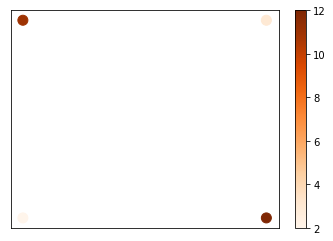

In [0]:
x, y = points(rows, cols)
c_matrix = count_matrix(kn, rows, cols, data)
print_matrix(c_matrix)
c = colors_array(c_matrix)
plt.scatter(x, y, s=[100 for _ in range(len(x))], c=c, cmap='Oranges')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.colorbar()

1,1
0,0
['Area', 'GDP', 'Inflation', 'Life.expect', 'Military', 'Pop.growth', 'Unemployment']
Austria
[83871.0, 41600.0, 3.5, 79.91, 0.8, 0.03, 4.2]
Belgium
[30528.0, 37800.0, 3.5, 79.65, 1.3, 0.06, 7.2]
Denmark
[43094.0, 37000.0, 2.8, 78.78, 1.3, 0.24, 6.1]
Germany
[357022.0, 38100.0, 2.5, 80.19, 1.5, -0.2, 6.0]
Iceland
[103000.0, 38100.0, 4.0, 81.0, 0.0, 0.67, 7.4]
Ireland
[70273.0, 40800.0, 2.6, 80.32, 0.9, 1.11, 14.4]
Italy
[301340.0, 30500.0, 2.9, 81.86, 1.8, 0.38, 8.4]
Luxembourg
[2586.0, 80600.0, 3.4, 79.75, 0.9, 1.14, 5.7]
Netherlands
[41543.0, 42000.0, 2.3, 80.91, 1.6, 0.45, 4.4]
Norway
[323802.0, 53400.0, 1.3, 80.32, 1.9, 0.33, 3.3]
Sweden
[450295.0, 40700.0, 3.0, 81.18, 1.5, 0.17, 7.5]
Switzerland
[41277.0, 44500.0, 0.2, 81.17, 1.0, 0.92, 2.8]

Bulgaria
[110879.0, 13800.0, 4.2, 73.84, 2.6, -0.8, 9.6]
Croatia
[56594.0, 18000.0, 2.3, 75.99, 2.39, -0.09, 17.7]
Estonia
[45228.0, 20400.0, 5.0, 73.58, 2.0, -0.65, 12.5]
Greece
[131957.0, 26300.0, 3.3, 80.05, 4.3, 0.06, 17.4]
Hungar

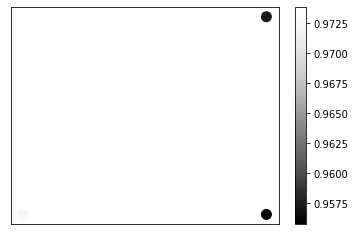

In [0]:
#Get countries in the same category for the two most voted neuron
max_i, max_j = 0, 0
max_i1, max_j1 = 0, 0
max_ = c_matrix[0][0]
max_1 = c_matrix[0][0]
for i in range(len(c_matrix)):
  for j in range(len(c_matrix[0])):
    if(max_ < c_matrix[i][j]):
      max_i1 = max_i
      max_j1 = max_j
      max_1 = max_
      max_i = i
      max_j = j
      max_ = c_matrix[i][j]
    elif(max_1 < c_matrix[i][j]):
      max_i1 = i
      max_j1 = j
      max_1 = c_matrix[i][j]
    elif(max_ == c_matrix[i][j]):
      max_i1 = i
      max_j1 = j
      max_1 = c_matrix[i][j]

print(str(max_i) + ',' + str(max_j))
print(str(max_i1) + ',' + str(max_j1))

print(headers[1:])

for i, datapoint in enumerate(data_aux):
  n = kn.get_winner_neuron(data[i])
  if(max_i == n[0] and max_j == n[1]):
    print(names[i])
    print(datapoint)

print()

for i, datapoint in enumerate(data_aux):
  n = kn.get_winner_neuron(data[i])
  if(max_i1 == n[0] and max_j1 == n[1]):
    print(names[i])
    print(datapoint)

print()

cluster1 = []
cluster2 = []
for i, datapoint in enumerate(data_aux):
  n = kn.get_winner_neuron(data[i])
  if(max_i == n[0] and max_j == n[1]):
    print(names[i])
    print(data[i])
    cluster1.append(data[i])

print()

for i, datapoint in enumerate(data_aux):
  n = kn.get_winner_neuron(data[i])
  if(max_i1 == n[0] and max_j1 == n[1]):
    print(names[i])
    print(data[i])
    cluster2.append(data[i])

u_matrix_ = u_matrix(kn, rows, cols)
print_matrix(u_matrix_)
x, y = points(rows, cols)
c = colors_array(u_matrix_)
plt.scatter(x, y, s=[100 for _ in range(len(x))], c=c, cmap='Greys_r')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.colorbar()

In [0]:
countries = []
for i, datapoint in enumerate(data):
  n = kn.get_winner_neuron(datapoint)
  if(n[0] == 23 and n[1] == 1):
    print(names[i])
    print(datapoint)

# **Resolución del problema de PCA**

# Clase de perceptrón lineal con regla de actualización de pesos de Oja

In [0]:
class OjaPerceptron:
  def __init__(self, dimension):
    self.weights = [0 for _ in range(dimension)]
    self.weights[0] = 1

  def dot_product(self, datapoint):
    product = 0
    for i in range(len(datapoint)):
      product += datapoint[i]*self.weights[i]
    return product

  def delta_weights(self, activation, datapoint):
    delta = self.weights.copy()
    for i in range(len(delta)):
      delta[i] = self.learning_rate*(datapoint[i]*activation - (activation**2)*self.weights[i])
    return delta

  def update_weights(self, delta):
    for i in range(len(self.weights)):
      self.weights[i] += delta[i]

  def pc(self, dataset, iterations):
    i = 0
    self.learning_rate = 1/100
    for t in range(iterations):
      datapoint = dataset[i]
      y = self.dot_product(datapoint)
      delta = self.delta_weights(y, datapoint)
      self.update_weights(delta)
      self.learning_rate = 1/(t + 100)
      i = (i + 1)%len(dataset)
    return self.weights.copy()

In [0]:
#Dataset
data_oja, names_oja, headers_oja = dataset()
normalize(data_oja)

rand.shuffle(data_oja)

p = OjaPerceptron(len(data_oja[0]))
p.pc(data_oja, 100000)
#De la librería: [ 0.1248739  -0.50050586  0.40651815 -0.48287333  0.18811162 -0.47570355 0.27165582]

[0.12496353150087786,
 -0.5005023930240411,
 0.4065728940757053,
 -0.4828978775628018,
 0.1880728813073457,
 -0.4757157002773814,
 0.27155871078728777]

# PCA con librería. Mismo código que el de la tarea de vehículos

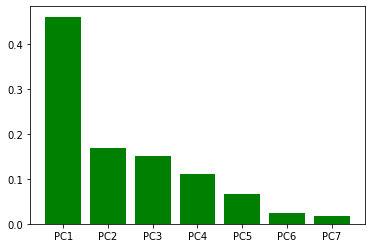

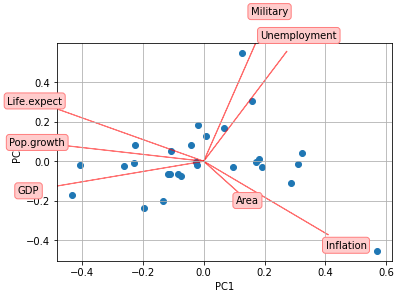

[ 0.1248739  -0.50050586  0.40651815 -0.48287333  0.18811162 -0.47570355
  0.27165582]


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Cargo el .csv
dataset_ = 'europe.csv'
data = pd.read_csv(dataset_)

#Consigo las características originales y el target (clase de vehículo)
features = ['Area', 'GDP', 'Inflation', 'Life.expect', 'Military', 'Pop.growth', 'Unemployment']
x = data[:][features].values
y = data[:][features].values

covariance_matrix = np.transpose(x).dot(x)

#Normalizo
x = StandardScaler().fit_transform(x)

#PCA
pca = PCA()
x_new = pca.fit_transform(x)

#Grafico varianza explicada en función de la componente
components = ['PC{}'.format(str(i)) for i in range(1, 8)]
x_pos = list(range(1,8))
plt.bar(x_pos, pca.explained_variance_ratio_, color='green')
plt.xticks(x_pos, components)
plt.show()

#Biplot
#Source: https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot

def myplot(score,coeff,y,wanted_features,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex,ys * scaley)
    for i in wanted_features:
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', 
            bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

wanted_features = [0, 1, 2, 3, 4, 5, 6]
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), y, wanted_features, features)
plt.show()
print(pca.components_[0])